# Train Trip Duration Model

## 1. Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [32]:
# Use mlflow
import mlflow

# Run mlflow in sqlite
mlflow.set_tracking_uri('sqlite:///mlflow.db')

# Create experiment if not exist, set experiment if already exist
mlflow.set_experiment('nyc-taxi-experiment-23')

2025/02/17 21:11:28 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment-23' does not exist. Creating a new experiment.


<Experiment: artifact_location='/home/arief/Desktop/projects/mlops_zoomcamp/module_2/mlruns/2', creation_time=1739801488499, experiment_id='2', last_update_time=1739801488499, lifecycle_stage='active', name='nyc-taxi-experiment-23', tags={}>

## 2. Load Data

In [3]:
df = pd.read_parquet('green_tripdata_2021-01.parquet')
print(len(df))
df.head()

76518


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [4]:
## Filter trip type
# df = df[df['trip_type'] == 2]

# Change column type
df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [5]:
# Get trip duration
df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']

# Change duration to minutes
df['duration'] = df['duration'].apply(lambda d: d.total_seconds()/60)

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


/tmp/ipykernel_8973/2904061269.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

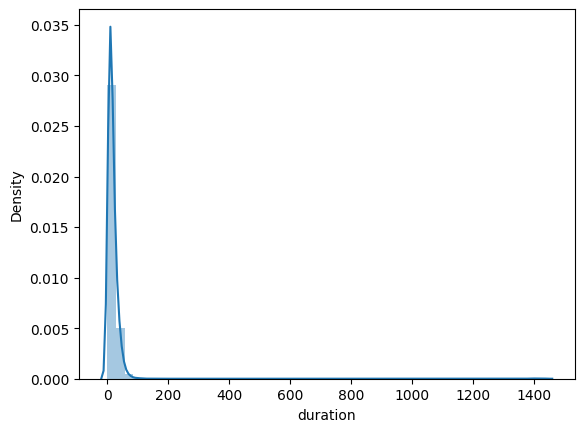

In [6]:
# Look at the distribution of duration
sns.distplot(df.duration)

In [7]:
df.duration.describe()

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
25%          8.000000
50%         13.883333
75%         23.000000
max       1439.600000
Name: duration, dtype: float64

In [8]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

In [9]:
df = df.query('1 <= duration <=60')
print(len(df))
df.head()

73908


,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


## 3. Feature Selection

In [10]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [11]:
# Change datatype to str so we can perform one hot encoding on it
df[categorical] = df[categorical].astype(str)

In [12]:
train_dicts = df[categorical + numerical].to_dict(orient='records')
# train_dicts

In [13]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [14]:
# Label/target
target = 'duration'
y_train = df[target].values

## 4. Train Model

In [15]:
def read_dataframe(filename):
    
    df = pd.read_parquet(filename)    
    # Change column type
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'])
    df['lpep_dropoff_datetime'] = pd.to_datetime(df['lpep_dropoff_datetime'])

    # Get trip duration
    df['duration'] = df['lpep_dropoff_datetime'] - df['lpep_pickup_datetime']
    # Change duration to minutes
    df['duration'] = df['duration'].apply(lambda d: d.total_seconds()/60)
    df = df.query('1 <= duration <=60')

    categorical = ['PULocationID', 'DOLocationID']
    # Change datatype to str so we can perform one hot encoding on it
    df[categorical] = df[categorical].astype(str)
    
    return df

In [16]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

/tmp/ipykernel_8973/76047919.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)
/tmp/ipykernel_8973/76047919.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [17]:
print(len(df_train))
print(len(df_val))

73908
61921


In [18]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [19]:
# Label/target
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [20]:
# Train a linear regression model
linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_val)

print(mean_squared_error(y_val, y_pred, squared=False))
print(mean_absolute_error(y_val, y_pred))

10.496651120495255
7.6040517359442


In [21]:
# Train a lasso regression model
lasso_regression = Lasso(alpha=0.001)

lasso_regression.fit(X_train, y_train)
y_pred = lasso_regression.predict(X_val)

print(mean_squared_error(y_val, y_pred, squared=False))
print(mean_absolute_error(y_val, y_pred))

10.481255832596219
7.601812923657592


In [22]:
# Train a lasso regression model
ridge_regression = Ridge()

ridge_regression.fit(X_train, y_train)
y_pred = ridge_regression.predict(X_val)

print(mean_squared_error(y_val, y_pred, squared=False))
print(mean_absolute_error(y_val, y_pred))

10.478171095846404
7.583645902844641


## 5. Modify Features

In [23]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [24]:
categorical = ['PU_DO']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [25]:
# Train a linear regression model
linear_regression = LinearRegression()

linear_regression.fit(X_train, y_train)
y_pred = linear_regression.predict(X_val)

print(mean_squared_error(y_val, y_pred, squared=False))
print(mean_absolute_error(y_val, y_pred))

7.758715208537182
5.339713111662927


In [26]:
with mlflow.start_run():

    mlflow.set_tag("developer", "arief")

    # Track data and hyperparameters with log_param
    mlflow.log_param("train-data-path", "green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path", "green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    # Train a lasso regression model
    lasso_regression = Lasso(alpha)

    lasso_regression.fit(X_train, y_train)
    y_pred = lasso_regression.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    # Track metric with log_metric
    mlflow.log_metric("rmse", rmse)

In [27]:
# Save linear regression model
import pickle

with open('lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, linear_regression), f_out)

## 6. Hyperparameter Tuning

In [30]:
# Hyperparameter tuning with hyperopt
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [ ]:
# Prepare data for xgboost
train = xgb.DMatrix(X_train, label=y_train)
val = xgb.DMatrix(X_val, label=y_val)

In [31]:
def objective(params):

    with mlflow.start_run():

        mlflow.set_tag("model", "xgboost")

        # Use log_params instead of log_param to log multiple
        # parameters simultaneously
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
    
        # Track metric with log_metric
        mlflow.log_metric("rmse", rmse)
    
    return {'loss': rmse, 'status':STATUS_OK}

In [ ]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)
